In [1]:
import os
import time
import lmdb
from itertools import chain

from joblib import dump

import matplotlib.pyplot as plt
from IPython import display

import numpy as np

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import theano
import theano.tensor as T
import lasagne.layers
import lasagne.nonlinearities 

from tqdm import tqdm_notebook

from nn_utils import build_UNet, iterate_minibatches
from train_data_preparation import prepare_data, extract_random_patches, extract_grid_patches

In [2]:
patch_size = 64
random_state = 42
n_classes = 2

grid_patches_params = {
    'patch_size': patch_size,
    'h_patches_number': 12,
    'w_patches_number': 12,
}

In [3]:
stack_path = '/home/efim/study/10 semester/course work/all_data/binary_data'
path_X = 'NLM'
path_Y = 'CAC'

In [4]:
stack_name = 'Urna_30'

prepare_data(
    os.path.join(stack_path, stack_name, path_X),
    os.path.join(stack_path, stack_name, path_Y),
    random_state, extract_grid_patches, grid_patches_params, 1
)

In [5]:
env = lmdb.open('../output_data/storage/input_images.lmdb')
print(env.info())
N = env.stat()["entries"]
print(N)
env.close()

{'max_readers': 126L, 'map_size': 2096377856L, 'last_pgno': 511810L, 'num_readers': 1L, 'map_addr': 0L, 'last_txnid': 1L}
102240


In [6]:
input_env = lmdb.open('../output_data/storage/input_images.lmdb')
labeled_env = lmdb.open('../output_data/storage/labeled_images.lmdb')
input_transaction = input_env.begin()
labeled_transaction = labeled_env.begin()

In [7]:
def get(transaction, _id, shape, dtype):
    _id = '{:06}'.format(_id)
    buf = transaction.get(_id.encode('ascii'))
    img = np.frombuffer(buf, dtype).reshape(shape)
    return img

In [8]:
def get_samples(input_transaction, labeled_transaction, ids, shape):
    X, Y = [], []
    for _id in ids:
        X.append(get(input_transaction, _id, shape, np.float32))
        Y.append(get(labeled_transaction, _id, shape, np.int8))
    return np.concatenate(X), np.concatenate(Y)

In [9]:
ids = np.arange(N)

In [10]:
train_ids = ids[: 5*N//6]
#test_ids = ids[1*N/3 : 2*N/3]
val_ids = ids[5*N//6:]

In [11]:
np.random.seed(random_state)

In [12]:
input_channels = 1
base_n_filters = 32
learning_rate = 1e-3
learning_rate_decay = 0.5
alpha = 1
smooth_const = 1e-5
nonlinearity = lasagne.nonlinearities.elu
num_epochs = 6
batch_size = 128

In [13]:
input_image = T.tensor4('input')
#target = T.matrix('output', dtype='int64')
target = T.ivector('output')

net = build_UNet(n_input_channels=input_channels, BATCH_SIZE=None, num_output_classes=n_classes,
                 pad='same', nonlinearity=nonlinearity,
                 input_dim=(patch_size, patch_size), base_n_filters=base_n_filters, do_dropout=True)

predictions = lasagne.layers.get_output(net['output_flattened'], input_image)
get_predictions = theano.function([input_image], predictions)

/home/efim/study/10 semester/reinforcement learning/AgentNet/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
/home/efim/study/10 semester/reinforcement learning/AgentNet/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode=self.mode,
/home/efim/study/10 semester/reinforcement learning/AgentNet/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode=self.mode,


In [14]:
net_weights = lasagne.layers.get_all_params(net['output_flattened'], trainable=True)

In [15]:
learning_rate_t = T.scalar('learning_rate', dtype='float32')
alpha_t = T.scalar('alpha', dtype='float32')
smooth_const_t = T.scalar('smooth_const', dtype='float32')

In [16]:
#smooth_iou = (predictions[:, 1] * target / (predictions[:, 1] + target - predictions[:, 1] * target)).mean()
reshaped_predictions = predictions[:, 1].reshape([-1, patch_size * patch_size])
reshaped_target = target.reshape([-1, patch_size * patch_size])
intersection =  (reshaped_predictions * reshaped_target).sum(axis=[1])
smooth_iou = ((2 * intersection + smooth_const_t)
    / (reshaped_predictions.sum(axis=[1]) + reshaped_target.sum(axis=[1]) + smooth_const_t)).mean()

train_loss = \
    lasagne.objectives.categorical_crossentropy(predictions, target).mean() 
# \
# - alpha_t * T.log(smooth_iou)

log_loss = lasagne.objectives.categorical_crossentropy(predictions, target).mean()

iou_loss = smooth_iou

acc_loss = lasagne.objectives.categorical_accuracy(predictions, target).mean()

In [17]:
updates = lasagne.updates.adam(train_loss, net_weights, learning_rate_t)

In [18]:
# train_function = theano.function(
#     [
#         input_image, 
#         target, 
#         learning_rate_t, 
#         alpha_t, 
#         smooth_const_t
#     ], train_loss, updates=updates)
#cum_loss_function = theano.function([input_image, target, alpha_t, smooth_const_t], train_loss)
train_function = theano.function(
    [
        input_image, 
        target, 
        learning_rate_t, 
    ], train_loss, updates=updates)
cum_loss_function = theano.function([input_image, target], train_loss)
log_loss_function = theano.function([input_image, target], log_loss)
iou_loss_function = theano.function([input_image, target, smooth_const_t], iou_loss)
acc_loss_function = theano.function([input_image, target], acc_loss)

In [19]:
try:
    os.mkdir('../output_data/predictions')
except OSError:
    pass

In [20]:
weights_dir = '../output_data/weights/Urna30_weights'
try:
    os.mkdir(weights_dir)
except OSError:
    pass

In [21]:
def apply_on_batches(ids, functions, params, results, epoch, validation_step, limit, iterations_name):
    for i, batch_ids in enumerate(iterate_minibatches(ids, batch_size)):
        inputs, targets = get_samples(
            input_transaction, 
            labeled_transaction, 
            batch_ids, 
            (1, input_channels, patch_size, patch_size)
        )
        targets = targets.flatten()
        for function, param, result in zip(functions, params, results):
            result.append(function(inputs, targets, *param))
        if i % validation_step == 0:
            print('    err on {} batch {}: {}'.format(iterations_name, i, results[0][-1]))
            if iterations_name == 'validation':
                dump_predictions(get_predictions, inputs, targets, '../output_data/predictions/epoch{}'.format(epoch), i)
        if i == limit:
            break

In [22]:
def dump_predictions(predictor, inputs, targets, path, batch_number):
    try:
        os.mkdir(path.format(epoch))
    except OSError:
        pass
    N = inputs.shape[0]
    #prediction = predictor(inputs).argmax(axis=1).reshape(N, patch_size, patch_size)
    prediction = predictor(inputs)[:, 1].reshape(N, patch_size, patch_size)
    targets = targets.reshape((N, patch_size, patch_size))

    for j in range(N):
        fig = plt.figure(figsize=(18, 6))
        
        ax1 = plt.subplot(1, 3, 1)
        ax1.imshow(inputs[j, 0], cmap='gray')
        
        ax2 = plt.subplot(1, 3, 2)
        prediction[j, 0, 0] = 0
        prediction[j, patch_size - 1, patch_size - 1] = 1
        ax2.imshow(prediction[j], cmap='gray')
        
        ax3 = plt.subplot(1, 3, 3)
        targets[j, 0, 0] = 0
        targets[j, patch_size - 1, patch_size - 1] = 1
        ax3.imshow(targets[j], cmap='gray')
    
        plt.savefig(os.path.join(path, 'batch{}_{}.png'.format(batch_number, j)))
        plt.close(fig)

In [23]:
plot_path = '../output_data/learning_progress.png'


def _get_loss_lists(epoch, batch_per_epoch, loss):
    y_batch = list(chain(*loss))
    y_epoch = []
    for i in range(epoch + 1):
        y = np.mean(y_batch[i*batch_per_epoch : (i+1)*batch_per_epoch])
        y_epoch += [y] * batch_per_epoch
    x = np.arange(len(y_batch))
    return x, y_batch, y_epoch


def plot_learning_progress(epoch, train_loss, val_log_loss, val_iou_loss, val_acc_loss):
    plt.close('all')
    
    fig = plt.figure(figsize=(16, 16))

    ax1 = plt.subplot(221)
    x, y_batch, y_epoch = _get_loss_lists(epoch, len(train_loss[-1]), train_loss)
    l1, = ax1.plot(x, y_batch)
    l2, = ax1.plot(x, y_epoch)
    ax1.set_ylim([1e-10, 10])
    ax1.set_yscale('log')
    ax1.set_title('train loss')
    
    ax2 = plt.subplot(222)
    x, y_batch, y_epoch = _get_loss_lists(epoch, len(val_log_loss[-1]), val_log_loss) 
    ax2.plot(x, y_batch)
    ax2.plot(x, y_epoch)
    ax2.set_ylim([1e-10, 10])
    ax2.set_yscale('log')
    ax2.set_title('validation log loss')
    
    ax3 = plt.subplot(223)
    x, y_batch, y_epoch = _get_loss_lists(epoch, len(val_iou_loss[-1]), val_iou_loss)
    ax3.plot(x, y_batch)
    ax3.plot(x, y_epoch)
    ax3.set_ylim([0, 1])
    ax3.set_title('validation approximated iou')
    
    ax4 = plt.subplot(224)
    x, y_batch, y_epoch = _get_loss_lists(epoch, len(val_acc_loss[-1]), val_acc_loss)
    ax4.plot(x, y_batch)
    ax4.plot(x, y_epoch)
    ax4.set_ylim([0, 1])
    ax4.set_title('validation accuracy')
    
    fig.legend((l1, l2), ('Loss by batch', 'Loss by epoch'), 'upper left')
    display.display(fig)
    plt.savefig(plot_path)

Epoch 1 of 6 took 35785.014s
  training loss (in-iteration):		0.033788
  validation loss:		0.02


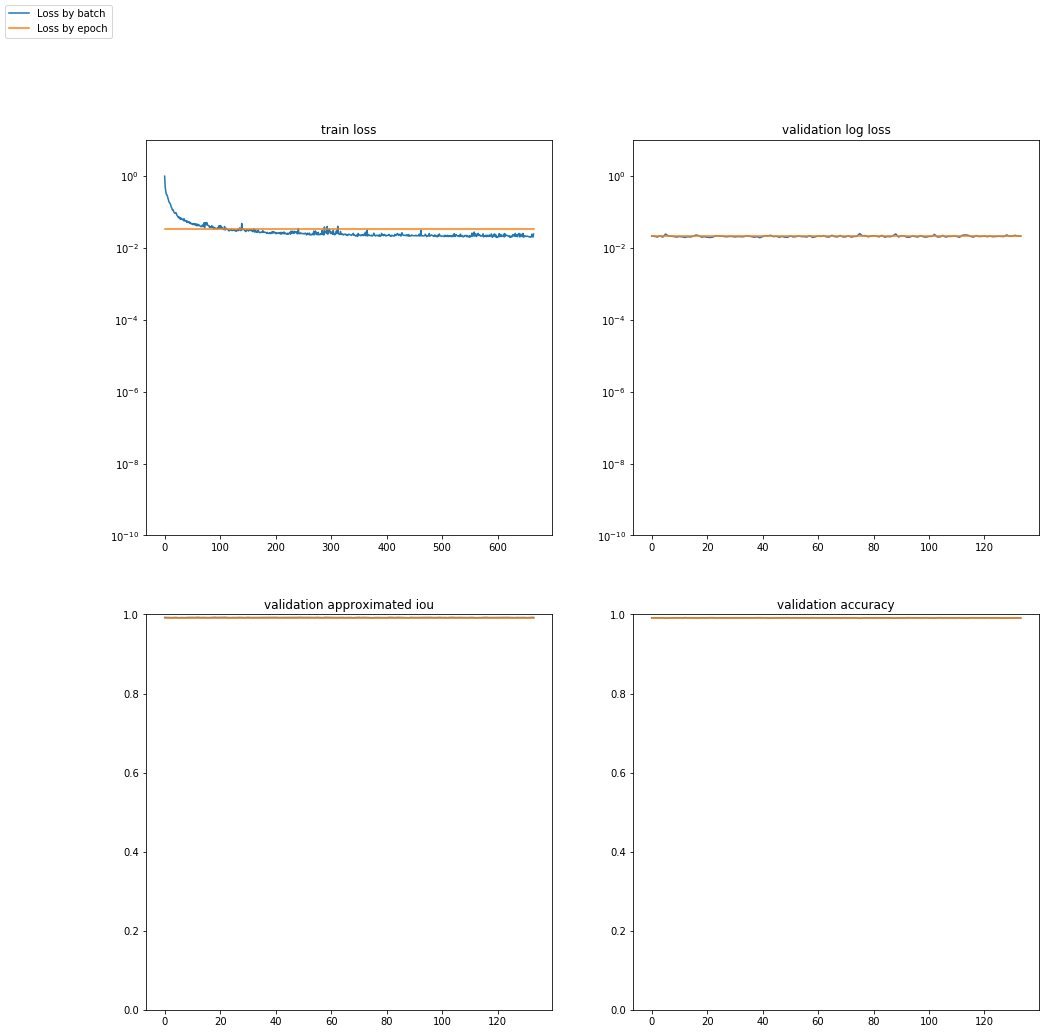

    err on train batch 0: 0.0198274834001
    err on train batch 20: 0.0197854134221
    err on train batch 40: 0.0200264011767
    err on train batch 60: 0.0202571292039
    err on train batch 80: 0.019364490315
    err on train batch 100: 0.0192086240256
    err on train batch 120: 0.0192935790172
    err on train batch 140: 0.0197346578938
    err on train batch 160: 0.0204806728981
    err on train batch 180: 0.0201046127523
    err on train batch 200: 0.0216490569003
    err on train batch 220: 0.019323849108
    err on train batch 240: 0.0205049091752
    err on train batch 260: 0.0191253347196
    err on train batch 280: 0.0191719291478
    err on train batch 300: 0.0199448202864


In [ ]:
train_loss = []
val_cum_loss = []
val_log_loss = []
val_iou_loss = []
val_acc_loss = []

for epoch in range(num_epochs):
    start_time = time.time()
    
    train_loss.append([])
    apply_on_batches(
        ids=train_ids, 
        functions=[train_function], 
        results=[train_loss[-1]], 
        params=[
            (
                np.float32(learning_rate), 
#                 np.float32(alpha), 
#                 np.float32(smooth_const),
            )
        ],
        epoch=epoch, 
        validation_step=20, 
        limit=-1,
        iterations_name='train'
    )
    
    val_cum_loss.append([])
    val_log_loss.append([])
    val_iou_loss.append([])
    val_acc_loss.append([])
    apply_on_batches(
        ids=val_ids, 
        functions=[
            cum_loss_function, log_loss_function, iou_loss_function, acc_loss_function
        ], 
        results=[
            val_cum_loss[-1], val_log_loss[-1], val_iou_loss[-1], val_acc_loss[-1]
        ], 
        params=[
#             (np.float32(alpha), np.float32(smooth_const)), 
            (),
            (), 
            (np.float32(smooth_const), ), 
            ()
        ], 
        epoch=epoch, 
        validation_step=20, 
        limit=-1,
        iterations_name='validation'
    )
    learning_rate *= learning_rate_decay
    
    display.clear_output(wait=True)

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(np.mean(train_loss[epoch])))
    print("  validation loss:\t\t{:.2f}".format(np.mean(val_cum_loss[epoch])))
    
    plot_learning_progress(epoch, train_loss, val_log_loss, val_iou_loss, val_acc_loss)

    dump(
        lasagne.layers.get_all_param_values(net['output_flattened']), 
        os.path.join(weights_dir, 'UNet_params_ep{:03}.jbl'.format(epoch))
    )

In [ ]:
# 1. Сделать график обучения и ошибки по батчам/эпохам
# 2. Сделать уменьшающийся learning rate
# 3. Сделать веса классов в loss
# 4. Добавить IoU в loss + слежение в процессе обучения
# 5. Добавить регуляризацию в loss